# log EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def acc_info(parent_path):
    """ epochごとに平均して最大値を求める """
    # 各foldのlogを結合
    df = pd.DataFrame()
    for csv_path in glob(log_path+"/train_log/*.csv"):
        df = pd.concat([df, pd.read_csv(csv_path)], axis=0)
    
    # epochごとにグルーピング
    average = df.groupby("epoch",as_index=False).mean()
    std = df.groupby("epoch",as_index=False).std()

    max_idx = average.val_acc.idxmax()
    max_acc = average.iloc[max_idx].val_acc
    max_std = std.iloc[max_idx].val_acc
    
    bathsize, adam_lr = log_path.split("/")[-1].split("_")
    
    info = {
        "batchsize": bathsize,
        "adam_lr": adam_lr,
        "best_acc": max_acc,
        "acc_std": max_std,
    }
    return info

In [103]:
df

,model_name,batchsize,adam_lr,best_acc,acc_std,dataset
0,CNN,32,0.001,0.982346,0.002558,mix_15
1,CNN,32,0.01,0.485422,0.431916,mix_15
2,CNN,64,0.001,0.982844,0.003186,mix_15
3,CNN,64,0.01,0.573778,0.565371,mix_15


In [21]:
dataset_list = ["2D_binary","3D_binary","inf_binary",
                "2D_neighbor10","2D_neighbor15","3D_neighbor10","3D_neighbor15","inf_neighbor10","inf_neighbor15",
               "mix_10", "mix_15"]


all_data = pd.DataFrame()

for dataset_name in dataset_list:
    print("="*10)
    print(dataset_name)
    for model_name in ["MLP", "CNN"]:
        df = pd.DataFrame()
        for log_path in sorted(glob(f"../logs/{dataset_name}/{model_name}/*")):
            info = acc_info(log_path)
            info["model_name"] = model_name
            info["dataset"] = dataset_name
            df = df.append(info, ignore_index=True)
            
        
        idx = df.best_acc.idxmax()
        max_acc = df.iloc[idx].best_acc
        std_acc = df.iloc[idx].acc_std
        
        d = {"dataset": dataset_name,"model_name": model_name, "acc": round(max_acc*100,2), "std": round(std_acc*100,2)}
        print(model_name, round(max_acc*100,2), "±", round(std_acc,2))
        
        all_data = all_data.append(d, ignore_index=True)

2D_binary
MLP 99.52 ± 0.0
CNN 99.72 ± 0.0
3D_binary
MLP 96.34 ± 0.04
CNN 99.81 ± 0.0
inf_binary
MLP 97.32 ± 0.01
CNN 99.1 ± 0.0
2D_neighbor10
MLP 94.69 ± 0.03
CNN 98.67 ± 0.0
2D_neighbor15
MLP 98.4 ± 0.0
CNN 99.1 ± 0.0
3D_neighbor10
MLP 79.65 ± 0.15
CNN 99.34 ± 0.0
3D_neighbor15
MLP 90.35 ± 0.15
CNN 99.56 ± 0.0
inf_neighbor10
MLP 81.52 ± 0.17
CNN 95.64 ± 0.01
inf_neighbor15
MLP 89.77 ± 0.14
CNN 97.09 ± 0.0
mix_10
MLP 48.72 ± 0.12
CNN 97.58 ± 0.0
mix_15
MLP 52.06 ± 0.19
CNN 98.28 ± 0.0


In [3]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

from tqdm import tqdm
from PIL import Image
from collections import Counter
from numpy.linalg import solve

from codes.models.MLP import MLP
from codes.models.StandardCNN import CNN
from codes.data_loader import set_transform

In [15]:
def binary_test_pred(model, data, cnn=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    xs, y1s, y2s=[],[],[]
    
    t = set_transform(100)
    
    for i in tqdm(range(0, 100)):
        # pich test data
        tensor = torch.Tensor()
        for sample in range(700, 800):
            img = Image.fromarray(data[i][sample] * 255)
            tensor = torch.cat([tensor,t(img)])
        
        if cnn:
            tensor = tensor.view([100,1,100,100])
        
        # pred
        with torch.no_grad():
            out = model(tensor.to(device))
            mean_pred = softmax(out, dim=1).mean(dim=0)
        
        xs.append(i+1)
        y1s.append( mean_pred[0].item() )
        y2s.append( mean_pred[1].item() )
    
    return xs, y1s, y2s

def transition_plot(x,y1,y2, ax, x_range=None,legend=True):
    """ 相転移確認プロット """
    ax.axvline(x=50, ymin=0, ymax=1, ls="dashed",color="gray",label="Critical(Ans)")
    ax.plot(x,y1,label="class:High",marker="o",color="red")
    ax.plot(x,y2,label="class:Low",marker="o",color="blue")
    ax.set_xlabel(r"$T$")
    ax.set_ylabel(r"Prob")
    ax.set_ylim(-.1,1.1)
    if x_range is not None:
        ax.set_xlim(x_range[0],x_range[1])
        ax.set_title(f"{x_range[0]} ~ {x_range[1]}")
    else:
        ax.set_title("Phase transition")
    
    if legend:
        ax.legend()
        
    

def cross_point(x,y1,y2, ax):
    # 交点を求める。
    harf = len(y1)//2
    u1,v1 = x[harf],y1[harf]
    u2,v2 = x[harf-1],y1[harf-1]
    w1,t1 = x[harf],y2[harf]
    w2,t2 = x[harf-1],y2[harf-1]

    tan1=(v2-v1)/(u2-u1)
    tan2=(t2-t1)/(w2-w1)
    MatA = [[1, -tan1],
            [1, -tan2]]

    vecB = [v1-tan1*u1,
            t1-tan2*w1]
    #
    sol = solve(MatA, vecB)
    #
    xx = np.linspace(0,100)
    yy = tan1*(xx-u1)+v1
    ax.plot(xx,yy,color="r")
    #
    yy = tan2*(xx-w1)+t1
    ax.plot(xx, yy,color="b")
    
    ax.set_ylim(0,1)
    ax.set_xlim(45,55)
    
    ax.axvline(x=50, ymin=0, ymax=1, ls="dashed",color="gray",label="Critical(Ans)")
    
    #
    beta_cr = 50
    er = round(abs(beta_cr - sol[1])/beta_cr  *100,2)
    ax.set_title(f"Relative error = {er} %")

def test_plot(dataset_name, model_name, path):
    # origin data
    if dataset_name.find("2D") != -1: 
        load_name = "snapshot_2D"
    elif dataset_name.find("3D") != -1: 
        load_name = "snapshot_3D"
    else:
        load_name = "snapshot_inf"
    
    f=open(f"../data/{load_name}.bin","rb")
    data=np.fromfile(f,dtype="int8").reshape([100,1000,100,100])
    # load model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if model_name == "MLP":
        model = MLP(2, 100).to(device)
    else:
        model = CNN(2, 100).to(device)
    
    model.load_state_dict(torch.load(path))
    # pred
    is_cnn = (model_name=="CNN")
    xs, y1s, y2s = binary_test_pred(model, data, cnn=is_cnn)
    
    fig, axes = plt.subplots(1,3, figsize=(16,4))
    # phase transition plot
    transition_plot(xs, y1s, y2s,axes[0])
    transition_plot(xs, y1s, y2s,axes[1], (45,55), legend=False)
    # 交点
    cross_point(xs, y1s, y2s,axes[2])
    plt.savefig(f"./plot/{dataset_name}_{model_name}")

In [20]:

dataset_list = ["2D_binary","3D_binary","inf_binary",
                "2D_neighbor10","2D_neighbor15","3D_neighbor10","3D_neighbor15","inf_neighbor10","inf_neighbor15"]

dataset_list = ["inf_neighbor15"]


all_data = pd.DataFrame()

for dataset_name in dataset_list:
    for model_name in ["MLP", "CNN"]:
        print("="*10)
        print(dataset_name, model_name)
        df = pd.DataFrame()
        for log_path in sorted(glob(f"../logs/{dataset_name}/{model_name}/*")):
            info = acc_info(log_path)
            info["model_name"] = model_name
            info["dataset"] = dataset_name
            df = df.append(info, ignore_index=True)
            
        m = df.best_acc.max()
        d = df.query("best_acc==@m").reset_index().loc[0]
        
#         path = f"../logs/{dataset_name}/{model_name}/{d.batchsize}_{d.adam_lr}/model_weight/fold3_trial0_epoch29.pth"
        path = f"../logs/{dataset_name}/{model_name}/64_0.001/model_weight/fold3_trial0_epoch29.pth"
        
        
        test_plot(dataset_name, model_name,path)
        plt.close()

inf_neighbor15 MLP


100%|██████████| 100/100 [00:02<00:00, 41.54it/s]


inf_neighbor15 CNN


100%|██████████| 100/100 [00:03<00:00, 32.55it/s]


In [30]:
def mix_test_pred(model, dataset_name="snapshot_2D", cnn=False):
    xs, y1s,y2s,y3s,y4s,y5s,y6s=[],[],[],[],[],[],[]
    
    t = set_transform(100)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    f=open(f"../data/{dataset_name}.bin","rb")
    data=np.fromfile(f,dtype="int8").reshape([100,1000,100,100])
    
    for i in tqdm(range(35,65)):
        # pich test data
        tensor = torch.Tensor()
        for sample in range(300, 400):
            img = Image.fromarray(data[i][sample] * 255)
            tensor = torch.cat([tensor,t(img)])
        if cnn:
            tensor = tensor.view([100,1,100,100])
        # pred
        with torch.no_grad():
            out = model(tensor.to(device))
            mean_pred = softmax(out, dim=1).mean(dim=0)
        
        xs.append(i+1)
        y1s.append( mean_pred[0].item() )
        y2s.append( mean_pred[1].item() )
        y3s.append( mean_pred[2].item() )
        y4s.append( mean_pred[3].item() )
        y5s.append( mean_pred[4].item() )
        y6s.append( mean_pred[5].item() )
    
    return xs, y1s,y2s,y3s,y4s,y5s,y6s



def transition_plot(x,y1,y2, ax, x_range=None,legend=True, title=None):
    """ 相転移確認プロット """
    ax.axvline(x=50, ymin=0, ymax=1, ls="dashed",color="gray",label="Critical(Ans)")
    ax.plot(x,y1,label="class:High",marker="o",color="red")
    ax.plot(x,y2,label="class:Low",marker="o",color="blue")
    ax.set_ylim(-.1,1.1)
    if x_range is not None:
        ax.set_xlim(x_range[0],x_range[1])
    if title is not None:
        ax.set_title(title)
    if legend:
        ax.legend()


def cross_point(x,y1,y2, ax):
    # 交点を求める。
    harf = len(y1)//2
    u1,v1 = x[harf],y1[harf]
    u2,v2 = x[harf-1],y1[harf-1]
    w1,t1 = x[harf],y2[harf]
    w2,t2 = x[harf-1],y2[harf-1]

    tan1=(v2-v1)/(u2-u1)
    tan2=(t2-t1)/(w2-w1)
    MatA = [[1, -tan1],
            [1, -tan2]]

    vecB = [v1-tan1*u1,
            t1-tan2*w1]
    
    sol = solve(MatA, vecB)
    xx = np.linspace(0,100)
    yy = tan1*(xx-u1)+v1
    # ax.plot(xx,yy,color="r")
    #
    yy = tan2*(xx-w1)+t1
    # ax.plot(xx, yy,color="b")
    # ax.set_ylim(0,1)
    # ax.set_xlim(40,60)
    # ax.axvline(x=50, ymin=0, ymax=1, ls="dashed",color="gray",label="Critical(Ans)")
    
    #
    beta_cr = 50
    er = round(abs(beta_cr - sol[1])/beta_cr  *100,2)
    ax.text(50, .95, f"Relative error = {er} %",
            horizontalalignment="center",fontstyle="italic",fontweight="bold")
        
        
def test_3data_plot(model, is_cnn):
    fig,axes = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey=True)

    ax = axes.ravel()
    ax[0].set_ylabel("testData=2D \n Prop")
    ax[3].set_ylabel("testData=3D \n Prop")
    ax[6].set_ylabel("testData=inf \n Prop")
    
    ax[6].set_xlabel(r"$T$")
    ax[7].set_xlabel(r"$T$")
    ax[8].set_xlabel(r"$T$")
    
    i = 0
    for name in ["snapshot_2D", "snapshot_3D", "snapshot_inf"]:
        if i == 0:
            name1, name2, name3 = "class:0,1","class:2,3","class:4,5"
        else:
            name1, name2, name3 = None,None,None
        
        xs, y1s,y2s,y3s,y4s,y5s,y6s = mix_test_pred(model, dataset_name=name, cnn=is_cnn)
        transition_plot(xs,y1s,y2s, ax[i], x_range=(30,70), title=name1, legend=False)
        transition_plot(xs,y3s,y4s, ax[i+1], x_range=(30,70), title=name2, legend=False)
        transition_plot(xs,y5s,y6s, ax[i+2], x_range=(30,70), title=name3, legend=False)
        
        cross_point(xs,y1s,y2s, ax[i])
        cross_point(xs,y3s,y4s, ax[i+1])
        cross_point(xs,y5s,y6s, ax[i+2])
        
        i+=3

def test_plot(model_name,path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if model_name == "MLP":
        model = MLP(6, 100).to(device)
    else:
        model = CNN(6,100).to(device)
    model.load_state_dict(torch.load(path))
    is_cnn = (model_name=="CNN")
    test_3data_plot(model, is_cnn)

mix_10 MLP


100%|██████████| 30/30 [00:00<00:00, 47.12it/s]


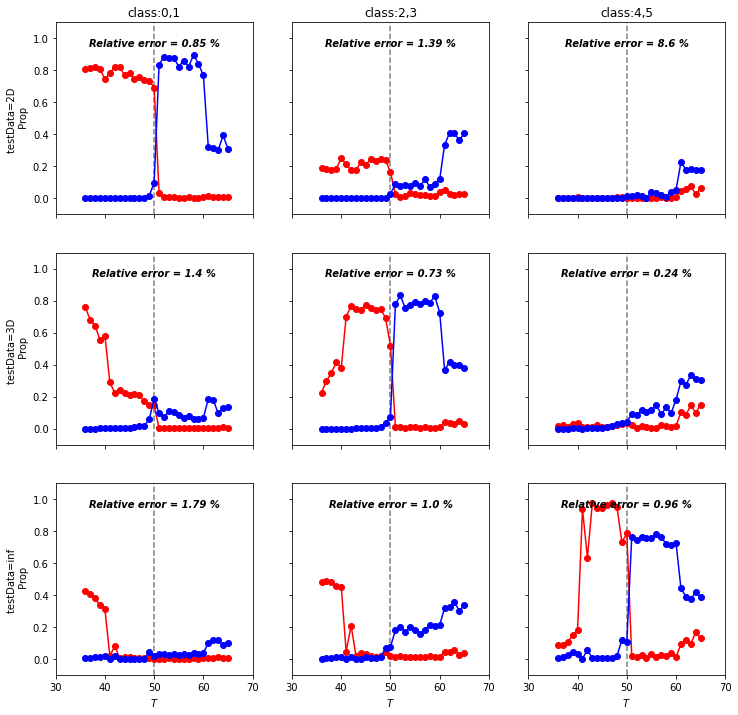

mix_10 CNN


100%|██████████| 30/30 [00:00<00:00, 34.83it/s]


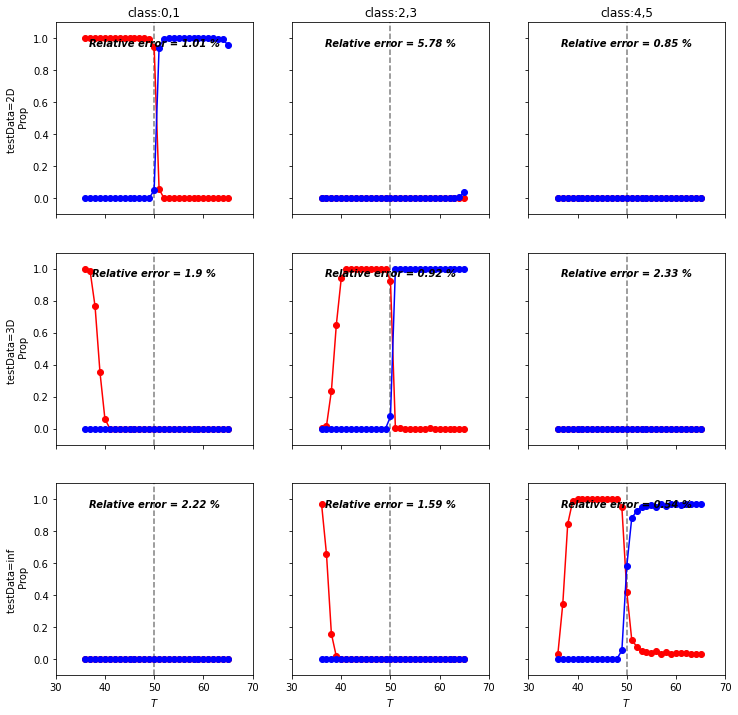

mix_15 MLP


100%|██████████| 30/30 [00:00<00:00, 47.03it/s]


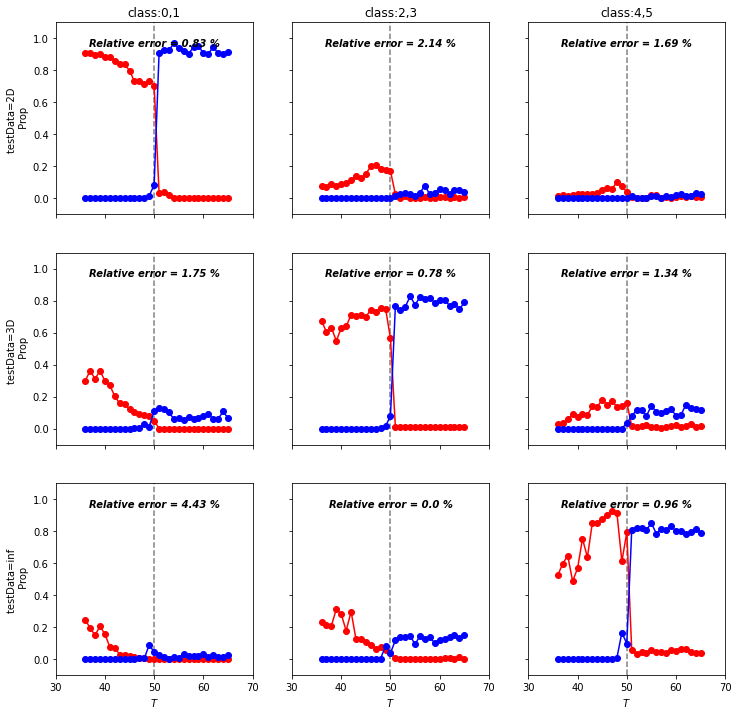

mix_15 CNN


100%|██████████| 30/30 [00:00<00:00, 32.17it/s]


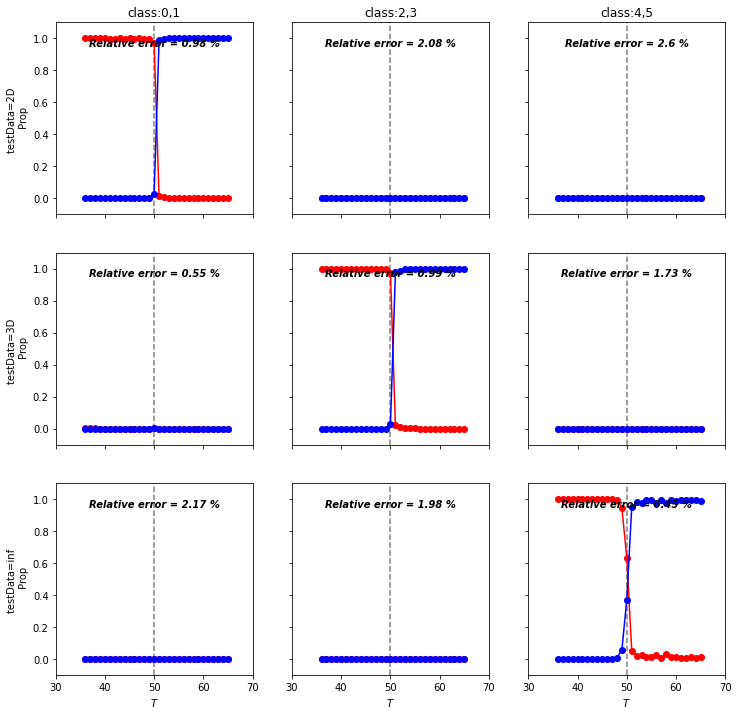

In [31]:
dataset_list = ["mix_10", "mix_15"]

all_data = pd.DataFrame()

for dataset_name in dataset_list:
    for model_name in ["MLP", "CNN"]:
        print("="*10)
        print(dataset_name, model_name)
        df = pd.DataFrame()
        for log_path in sorted(glob(f"../logs/{dataset_name}/{model_name}/*")):
            info = acc_info(log_path)
            info["model_name"] = model_name
            info["dataset"] = dataset_name
            df = df.append(info, ignore_index=True)
            
        m = df.best_acc.max()
        d = df.query("best_acc==@m").reset_index().loc[0]
        
#         path = f"../logs/{dataset_name}/{model_name}/{d.batchsize}_{d.adam_lr}/model_weight/fold3_trial0_epoch29.pth"
        path = f"../logs/{dataset_name}/{model_name}/64_0.001/model_weight/fold1_trial0_epoch29.pth"
        
        
        test_plot(model_name,path)
        plt.savefig(f"./plot/{dataset_name}_{model_name}.png")
        plt.show()